In [1]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm  # Import tqdm for progress bar
import seaborn as sns
from myMLlib import set_seed,plt_confusion,plt_loss 

In [2]:
set_seed(41)
folderpath_first = '/home/yuqster/files/research/dataset/Oil_mix19'
folderpath_second = '/home/yuqster/files/research/dataset/Oil_mix20'
folderpath_third = '/home/yuqster/files/research/dataset/Oil_mix21'
data_list_first = []
labels_first = []
data_list_second = []
labels_second = []
data_list_third = []
labels_third = []
material = ['oil','vinegar','water']

In [3]:
file_name = []
for i in range(len(material)):
    file_name.append([f for f in os.listdir(folderpath_second) if material[i] in f])
    for path in file_name[i]:
        data = pd.read_csv(f'{folderpath_second}/{path}')
        trans = data.values
        data_list_second.append(trans)
        labels_second.append(i)

In [4]:
file_name = []
for i in range(len(material)):
    file_name.append([f for f in os.listdir(folderpath_third) if material[i] in f])
    for path in file_name[i]:
        data = pd.read_csv(f'{folderpath_third}/{path}')
        trans = data.values
        data_list_third.append(trans)
        labels_third.append(i)

In [5]:

data_list = data_list_second + data_list_third
labels = labels_second + labels_third

X = np.array(data_list).squeeze()
y = np.array(labels).reshape(-1, 1)
print(X.shape)
print(y.shape)

(11211, 4096)
(11211, 1)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
# Standardize the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
scaler = MinMaxScaler(feature_range=(0, len(material)-1))
y_test = scaler.fit_transform(y_test)
y_train = scaler.fit_transform(y_train)
print(y_train)

[[2.]
 [1.]
 [2.]
 ...
 [2.]
 [2.]
 [2.]]


In [8]:
class auto_encoder(nn.Module):

    def __init__(self):
        super(auto_encoder, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 10)
        self.fc3 = nn.Linear(10, 128)
        self.fc4 = nn.Linear(128, X_train.shape[1])

    def forward(self, input):
        hidden1 = torch.relu(self.fc1(input))
        hidden2 = torch.relu(self.fc2(hidden1))
        hidden3 = torch.relu(self.fc3(hidden2))
        output = self.fc4(hidden3)
        return output, hidden2

In [9]:
class ANN_Model(nn.Module):

    def __init__(self):
        super(ANN_Model, self).__init__()
        self.fc1 = nn.Linear(10, 8)
        self.fc2 = nn.Linear(8, 6)
        self.fc3 = nn.Linear(6, 4)

    def forward(self, input):
        hidden1 = torch.relu(self.fc1(input))
        hidden2 = torch.relu(self.fc2(hidden1))
        output = self.fc3(hidden2)
        return output

In [10]:
model = ANN_Model().to(device)
auto_model = auto_encoder().to(device)
auto_criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
auto_optimizer = optim.AdamW(auto_model.parameters(),lr = 2e-4)

# 4. 将 numpy 数据转为 torch 张量并移动到 device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [11]:
num_epochs = 10000
train_losses = []
test_losses = []

# 确保 y_train_tensor 已经是 long 类型
y_train_tensor = y_train_tensor.squeeze().long()

pbar = tqdm(range(num_epochs), desc="Training", leave=True)
for epoch in pbar:
    # —— 1. 训练 —— #
    auto_model.train()
    auto_optimizer.zero_grad()
    outputs, _ = auto_model(X_train_tensor)
    train_loss = auto_criterion(outputs, X_train_tensor)
    train_loss.backward()
    auto_optimizer.step()
    train_losses.append(train_loss.item())
    
    # —— 2. 验证 —— #
    auto_model.eval()
    with torch.no_grad():
        test_outputs, _ = auto_model(X_test_tensor)    # 假设你已有 X_test_tensor
        test_loss = auto_criterion(test_outputs, X_test_tensor)
        test_losses.append(test_loss.item())

    # —— 3. 更新 tqdm 的显示 —— #
    pbar.set_postfix(train_loss=train_loss.item(), test_loss=test_loss.item())

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training: 100%|██████████| 10000/10000 [01:12<00:00, 137.78it/s, test_loss=0.122, train_loss=0.111]


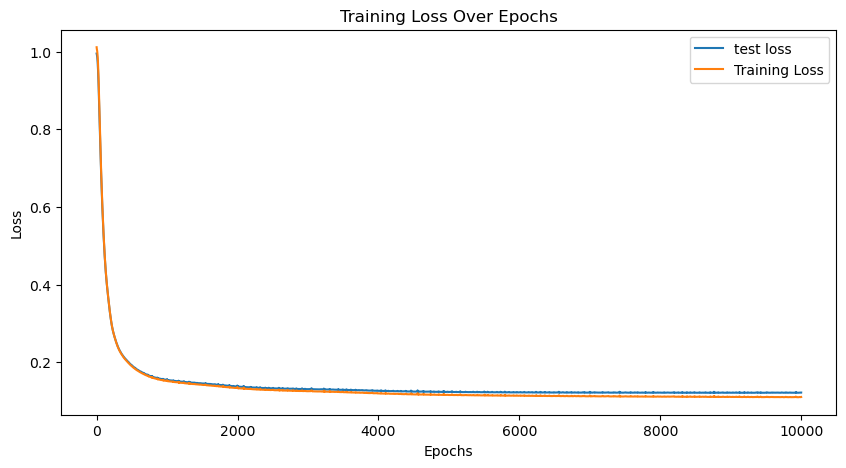

In [14]:
plt_loss(train_losses, test_losses)

In [ ]:
_,X_train_auto = auto_model(X_train_tensor)
_,X_test_auto = auto_model(X_test_tensor)
X_train_auto = X_train_auto.detach()
X_test_auto = X_test_auto.detach()

In [ ]:
X_train_auto_np = X_train_auto.cpu().numpy()

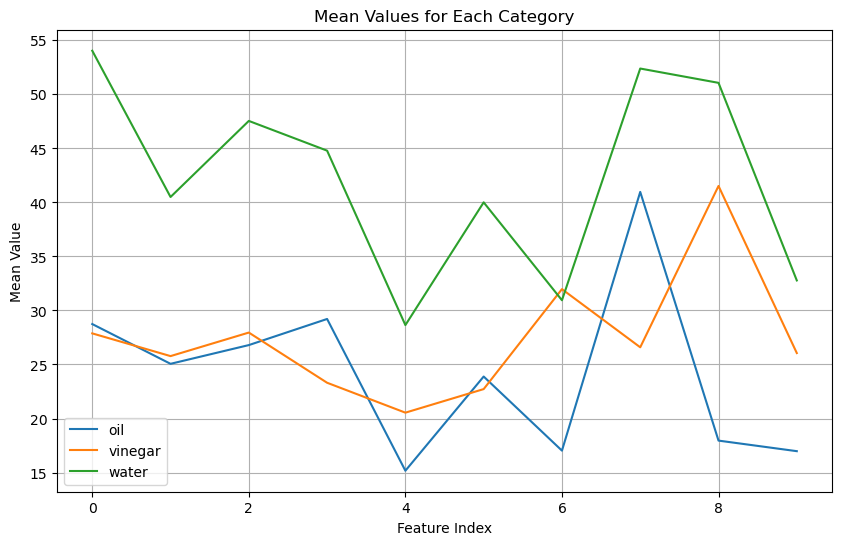

In [ ]:
unique_labels = np.unique(y_train)
plt.figure(figsize=(10,6))
for label in unique_labels:
    # 获取当前类别下的样本索引
    indices = np.where(y_train.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X_train_auto_np[indices].mean(axis=0)
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{material[int(label)]}")
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values for Each Category")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 5. 训练模型
num_epochs = 10000
train_losses = []

# # Convert y_train_tensor to the correct type
# y_train_tensor = y_train_tensor.squeeze().long() # Remove extra dimension and convert to long
pbar = tqdm(range(num_epochs), desc="Training", leave=True)
for epoch in pbar:
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_auto)
    loss2 = criterion(outputs, y_train_tensor)
    loss2.backward()
    optimizer.step()
    train_losses.append(loss2.item())
    pbar.set_postfix(loss2=loss2.item())

Training: 100%|██████████| 10000/10000 [00:08<00:00, 1134.50it/s, loss2=2.28e-5]


In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_auto)
    train_outputs = model(X_train_auto)
    _, predicted = torch.max(test_outputs, 1)
    _, predicted_train = torch.max(train_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    predicted_np_train = predicted_train.cpu().numpy()
    accuracy_train = accuracy_score(y_train,predicted_np_train)
    accuracy = accuracy_score(y_test, predicted_np)
    cm = confusion_matrix(y_test, predicted_np)

Accuracy: 0.9988109393579072
Accuracy_train: 1.0
Confusion Matrix:
[[1144    0    1]
 [   0 1138    0]
 [   3    0 1078]]


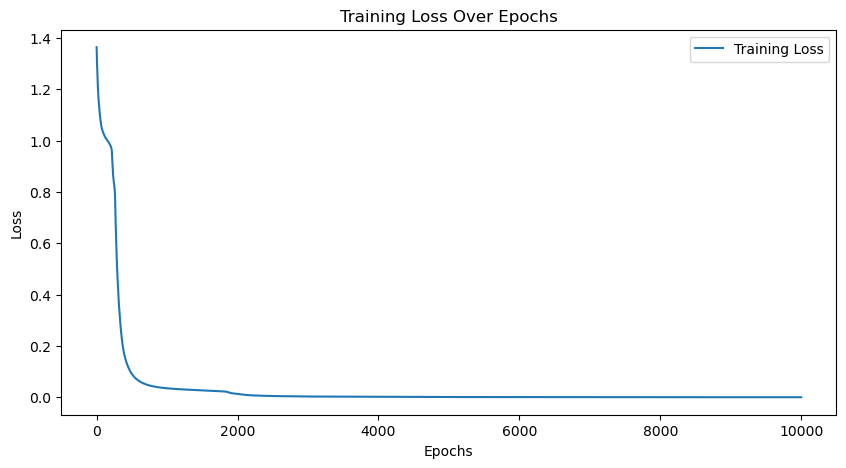

In [ ]:
print(f'Accuracy: {accuracy}')
print(f'Accuracy_train: {accuracy_train}')
print(f'Confusion Matrix:\n{cm}')

# 7. 可视化训练损失
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

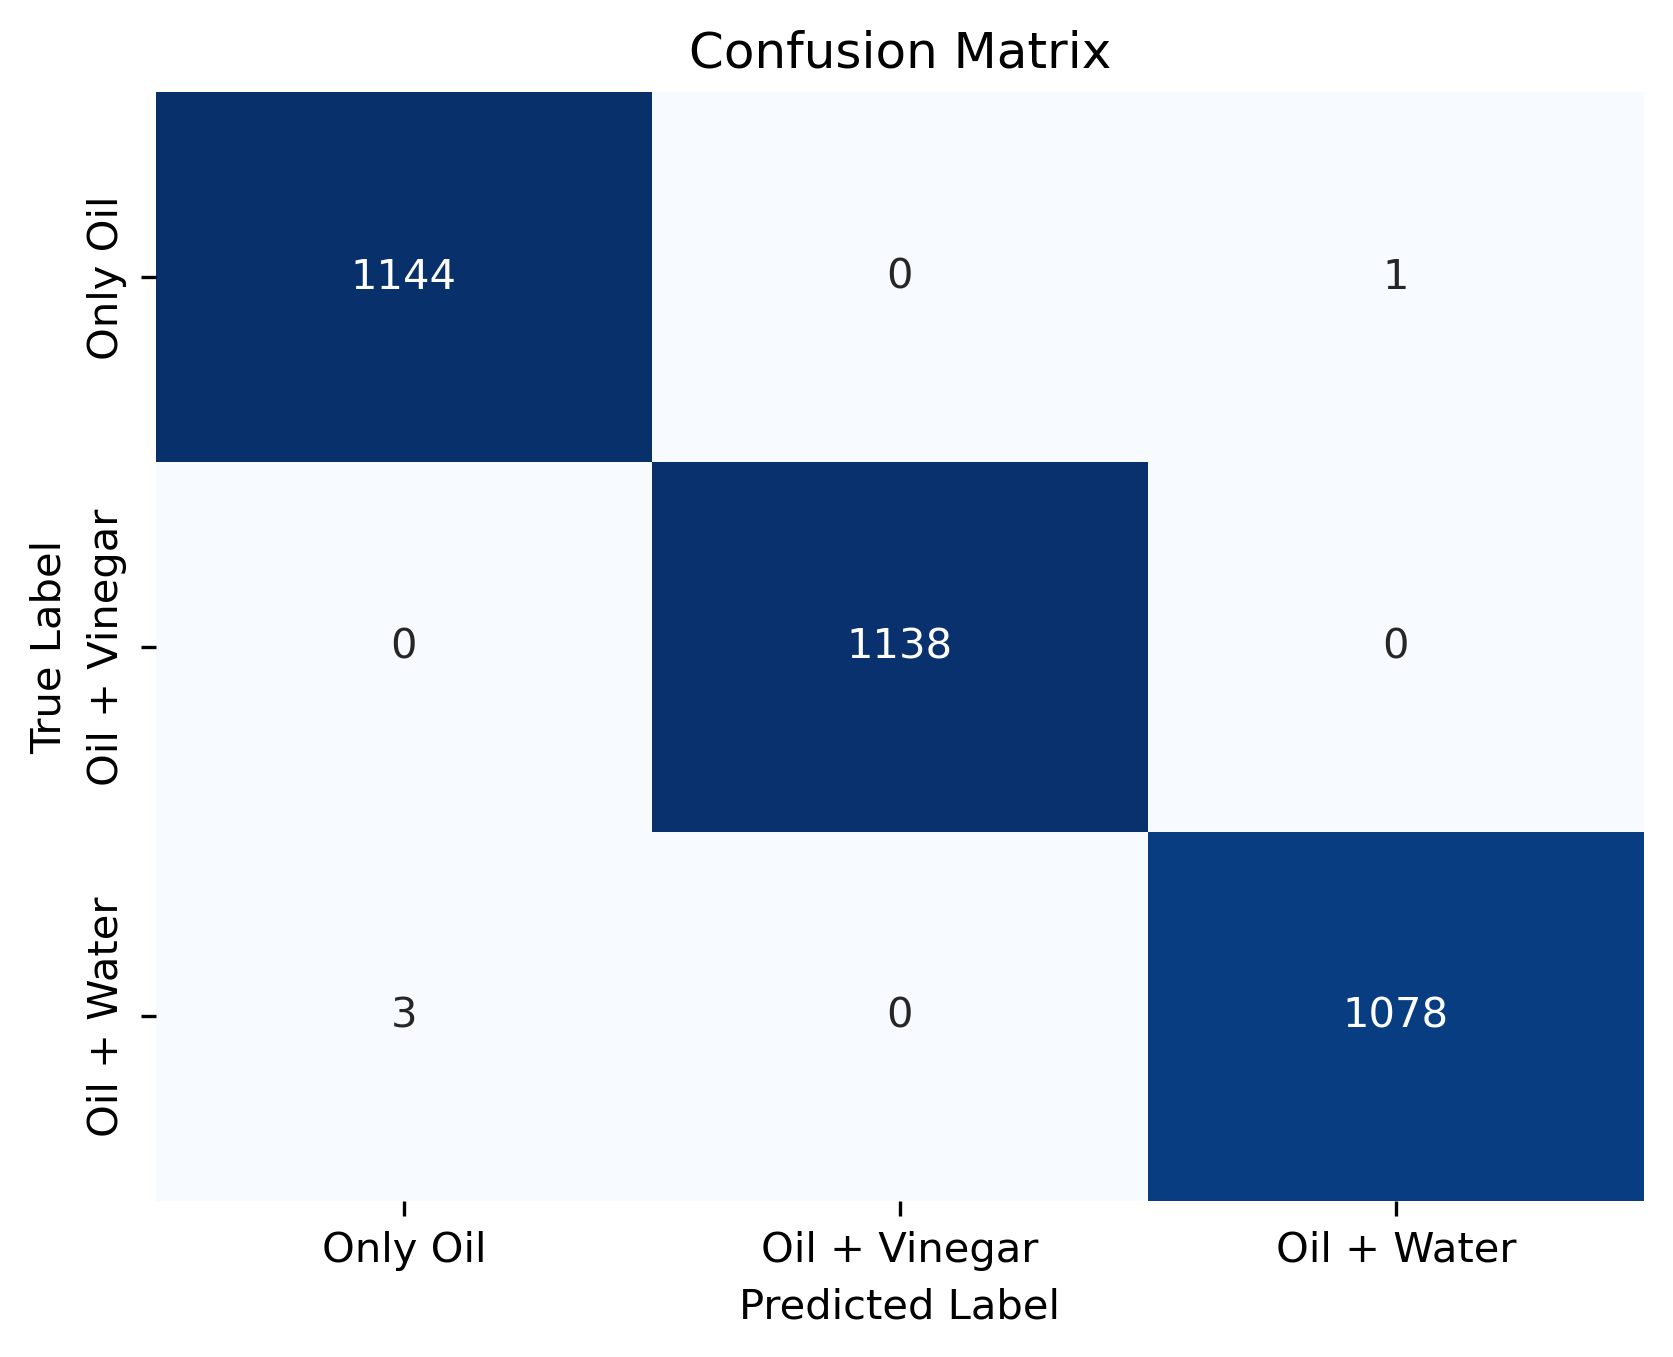

Accuracy: 0.9988109393579072
              precision    recall  f1-score   support

         oil       1.00      1.00      1.00      1145
     vinegar       1.00      1.00      1.00      1138
       water       1.00      1.00      1.00      1081

    accuracy                           1.00      3364
   macro avg       1.00      1.00      1.00      3364
weighted avg       1.00      1.00      1.00      3364



In [ ]:
# Plot Confusion Matrix
name = ['Only Oil', 'Oil + Vinegar', 'Oil + Water']
plt.figure(dpi=300)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=name,
            yticklabels=name,
            cbar=False)  # 关闭 color bar
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Save as PDF before show()
plt.savefig("/home/yuqster/files/research/figures/confusion.pdf", bbox_inches='tight')
plt.show()


# Convert y_test to integer labels
y_test_int = y_test.astype(int)

# Show classification reportaccuracy
report = classification_report(y_test_int, predicted_np,
                               target_names=material, labels=range(len(material)))
print("Accuracy:", accuracy)
print(report)

In [ ]:
# 获取模型的权重字典
weight = model.state_dict()  # 需要加上括号调用方法

# 打印 fc1 层的权重
print(weight['fc1.weight'])


tensor([[-0.0679, -0.0775,  0.6838,  0.0582, -0.4256,  0.3497, -0.5918, -0.3639,
          0.5334,  0.0077],
        [-0.4354, -0.1154,  0.0574, -0.3057, -0.1805,  0.0986,  0.7900,  0.0390,
         -0.0440,  0.4106],
        [ 0.4826,  0.7025,  0.1859,  0.5551,  0.3191, -0.1915, -0.6725,  0.2034,
         -0.4686, -0.8118],
        [ 0.2018,  0.2759,  0.1562, -0.0573,  0.2465, -0.3075,  0.1681,  0.2094,
          0.7495, -0.4842],
        [-1.1929,  0.2461,  0.0528, -1.0221,  0.8549, -0.2040, -0.9083,  0.1981,
          0.0499,  1.0521],
        [-0.2483,  0.0110, -0.0037, -0.2445, -0.0554, -0.2622,  0.0618,  0.0482,
          0.1637,  0.0072],
        [-0.5267,  1.1118, -1.0880, -0.0462,  1.0075, -0.5735,  0.9216,  0.1310,
          0.3932, -0.2716],
        [ 0.1580,  0.0279, -0.1345, -0.1405, -0.3391, -0.1491,  0.1485, -0.2030,
          0.4084,  0.1196]], device='cuda:0')
